In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Path to your dataset
cbis_path = r"C:\Users\Asus\Downloads\Atelier\Atelier2025_SCI_1st_Dataset (2)"
img_size = (150, 150)

# Load images and labels
def load_images_and_labels():
    images = []
    labels = []
    class_names = ['Normal', 'Pneumonia', 'Pneumonia-Viral']
    label_map = {'Normal': 0, 'Pneumonia': 1, 'Pneumonia-Viral': 1}
    for class_name in class_names:
        class_path = os.path.join(cbis_path, class_name)
        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label_map[class_name])
    return np.array(images), np.array(labels)
# Load and preprocess data
images, labels = load_images_and_labels()
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

# Split into train, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# Class balancing
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Data generators (no augmentation)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.00005)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(48, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[earlystopping, checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best model
best_model = models.load_model('best_model.h5')

# Evaluate
test_loss, test_acc = best_model.evaluate(test_generator, verbose=0)
print(f"\nBest Model Test Accuracy: {test_acc:.4f}")
print(f"Best Model Test Loss: {test_loss:.4f}")

# Predictions
preds = best_model.predict(test_generator)
pred_classes = np.rint(preds)

# Classification report
print(classification_report(test_labels, pred_classes, digits=4))

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │         602,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 990,049 (3.78 MB)

 Trainable params: 990,049 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7846 - loss: 0.5192
Epoch 1: val_loss improved from inf to 0.43052, saving model to best_model.h5


260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 247ms/step - accuracy: 0.7849 - loss: 0.5186 - val_accuracy: 0.8824 - val_loss: 0.4305
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9164 - loss: 0.2848
Epoch 2: val_loss improved from 0.43052 to 0.17167, saving model to best_model.h5


260/260 ━━━━━━━━━━━━━━━━━━━━ 62s 239ms/step - accuracy: 0.9165 - loss: 0.2845 - val_accuracy: 0.9375 - val_loss: 0.1717
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9636 - loss: 0.1286
Epoch 3: val_loss improved from 0.17167 to 0.10067, saving model to best_model.h5


260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 247ms/step - accuracy: 0.9636 - loss: 0.1285 - val_accuracy: 0.9690 - val_loss: 0.1007
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9776 - loss: 0.0867
Epoch 4: val_loss improved from 0.10067 to 0.07342, saving model to best_model.h5


260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 259ms/step - accuracy: 0.9776 - loss: 0.0867 - val_accuracy: 0.9775 - val_loss: 0.0734
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9799 - loss: 0.0842
Epoch 5: val_loss improved from 0.07342 to 0.05222, saving model to best_model.h5


260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - accuracy: 0.9799 - loss: 0.0843 - val_accuracy: 0.9899 - val_loss: 0.0522
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9856 - loss: 0.0790
Epoch 6: val_loss did not improve from 0.05222
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 245ms/step - accuracy: 0.9856 - loss: 0.0789 - val_accuracy: 0.9882 - val_loss: 0.0560
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9888 - loss: 0.0617
Epoch 7: val_loss did not improve from 0.05222
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 245ms/step - accuracy: 0.9888 - loss: 0.0617 - val_accuracy: 0.9876 - val_loss: 0.0600
Epoch 8/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9882 - loss: 0.0517
Epoch 8: val_loss did not improve from 0.05222
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 268ms/step - accuracy: 0.9882 - loss: 0.0518 - val_accuracy: 0.9831 - val_loss: 0.0636
Epoch 8: early stopping



Best Model Test Accuracy: 0.9916
Best Model Test Loss: 0.0380
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
              precision    recall  f1-score   support

           0     0.9941    0.9961    0.9951      1529
           1     0.9756    0.9639    0.9697       249

    accuracy                         0.9916      1778
   macro avg     0.9849    0.9800    0.9824      1778
weighted avg     0.9915    0.9916    0.9915      1778



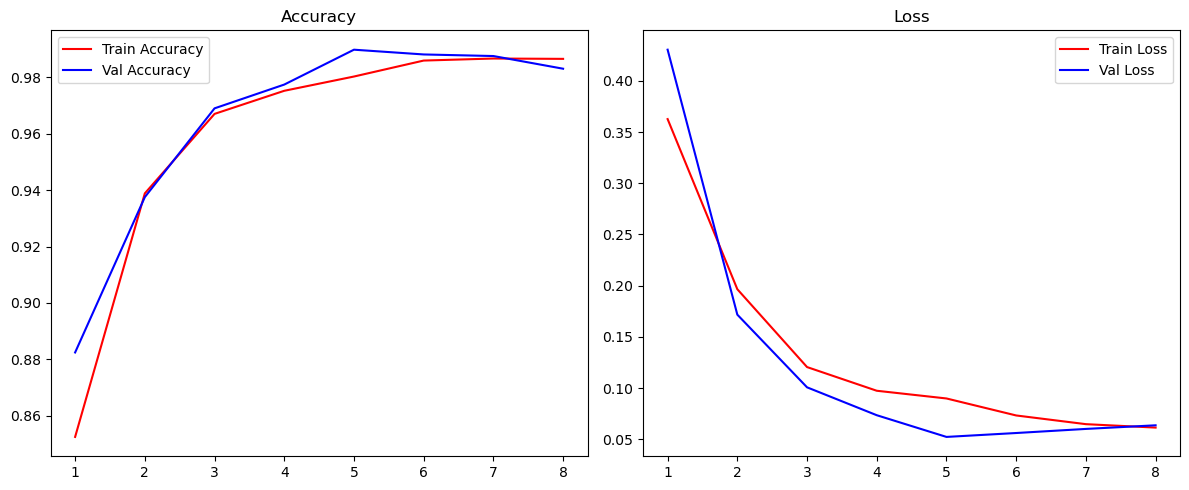

In [2]:
# Plot
tra_loss = history.history['loss']
tra_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(tra_acc)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tra_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tra_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

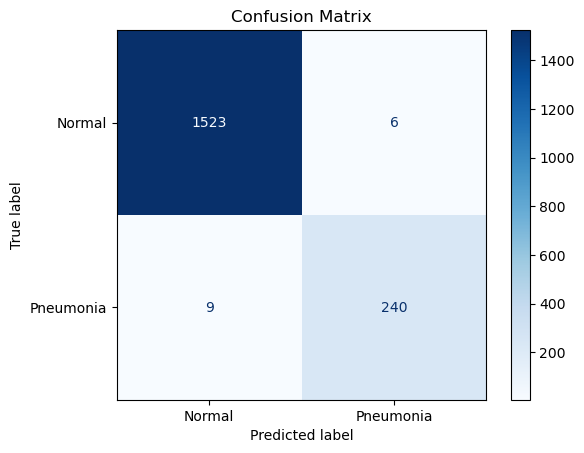

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia-Viral'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
